In [ ]:
import numpy as np
import random

from scipy.optimize import brentq

def calc_gamma(t, T, lambda_vec: list | np.ndarray):
    l1, l2, l3, l4, l5, l6 = lambda_vec
    s = t/T

    def _x_tau_minus_s(tau):
        x_tau = 3* l1 *((1- tau)**2) * tau \
              + 3 *l3*(1- tau) * (tau**2) \
                  + tau**3 
        return (x_tau - s)
    
    if s <= 0.0:
        tau = 0.0
    elif s >= 1.0:
        tau = 1.0
    else:
        try:
            tau = brentq(_x_tau_minus_s, 0.0, 1.0)
        except ValueError:
            tau = s
    
    y_tau = ((1 - tau)**3) + \
        (3 * l2 *   ((1- tau)**2) * tau) + \
            (3 * l4 * (1 - tau) * (tau**2)) 

    start_gamma = 10 ** (2.0 * l5)
    end_gamma = 10 ** (-3.0 * l6)
    # print(start_gamma, end_gamma)
    gamma = y_tau * start_gamma + (1 - y_tau) * end_gamma

    return gamma


# k = [1, 2, 3]
r = 3
T = 10
delta_t = T/r

lambda_vec = [round(random.uniform(0, 1), 3) for i in range(4)] + [round(random.random(), 3) for _ in range(2)]

print(lambda_vec)



[0.641, 0.023, 0.5, 0.554, 0.822, 0.761]


SparsePauliOp(['XIII', 'IXII', 'IIXI', 'IIIX'],
              coeffs=[1.66666667+0.j, 1.66666667+0.j, 1.66666667+0.j, 1.66666667+0.j])
SparsePauliOp(['IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[3.02098758+0.j, 3.07855803+0.j, 3.26645289+0.j, 2.51501527+0.j,
 1.51608983+0.j, 1.51000473+0.j, 1.51355398+0.j, 1.51004459+0.j,
 1.51540905+0.j, 1.51057796+0.j])


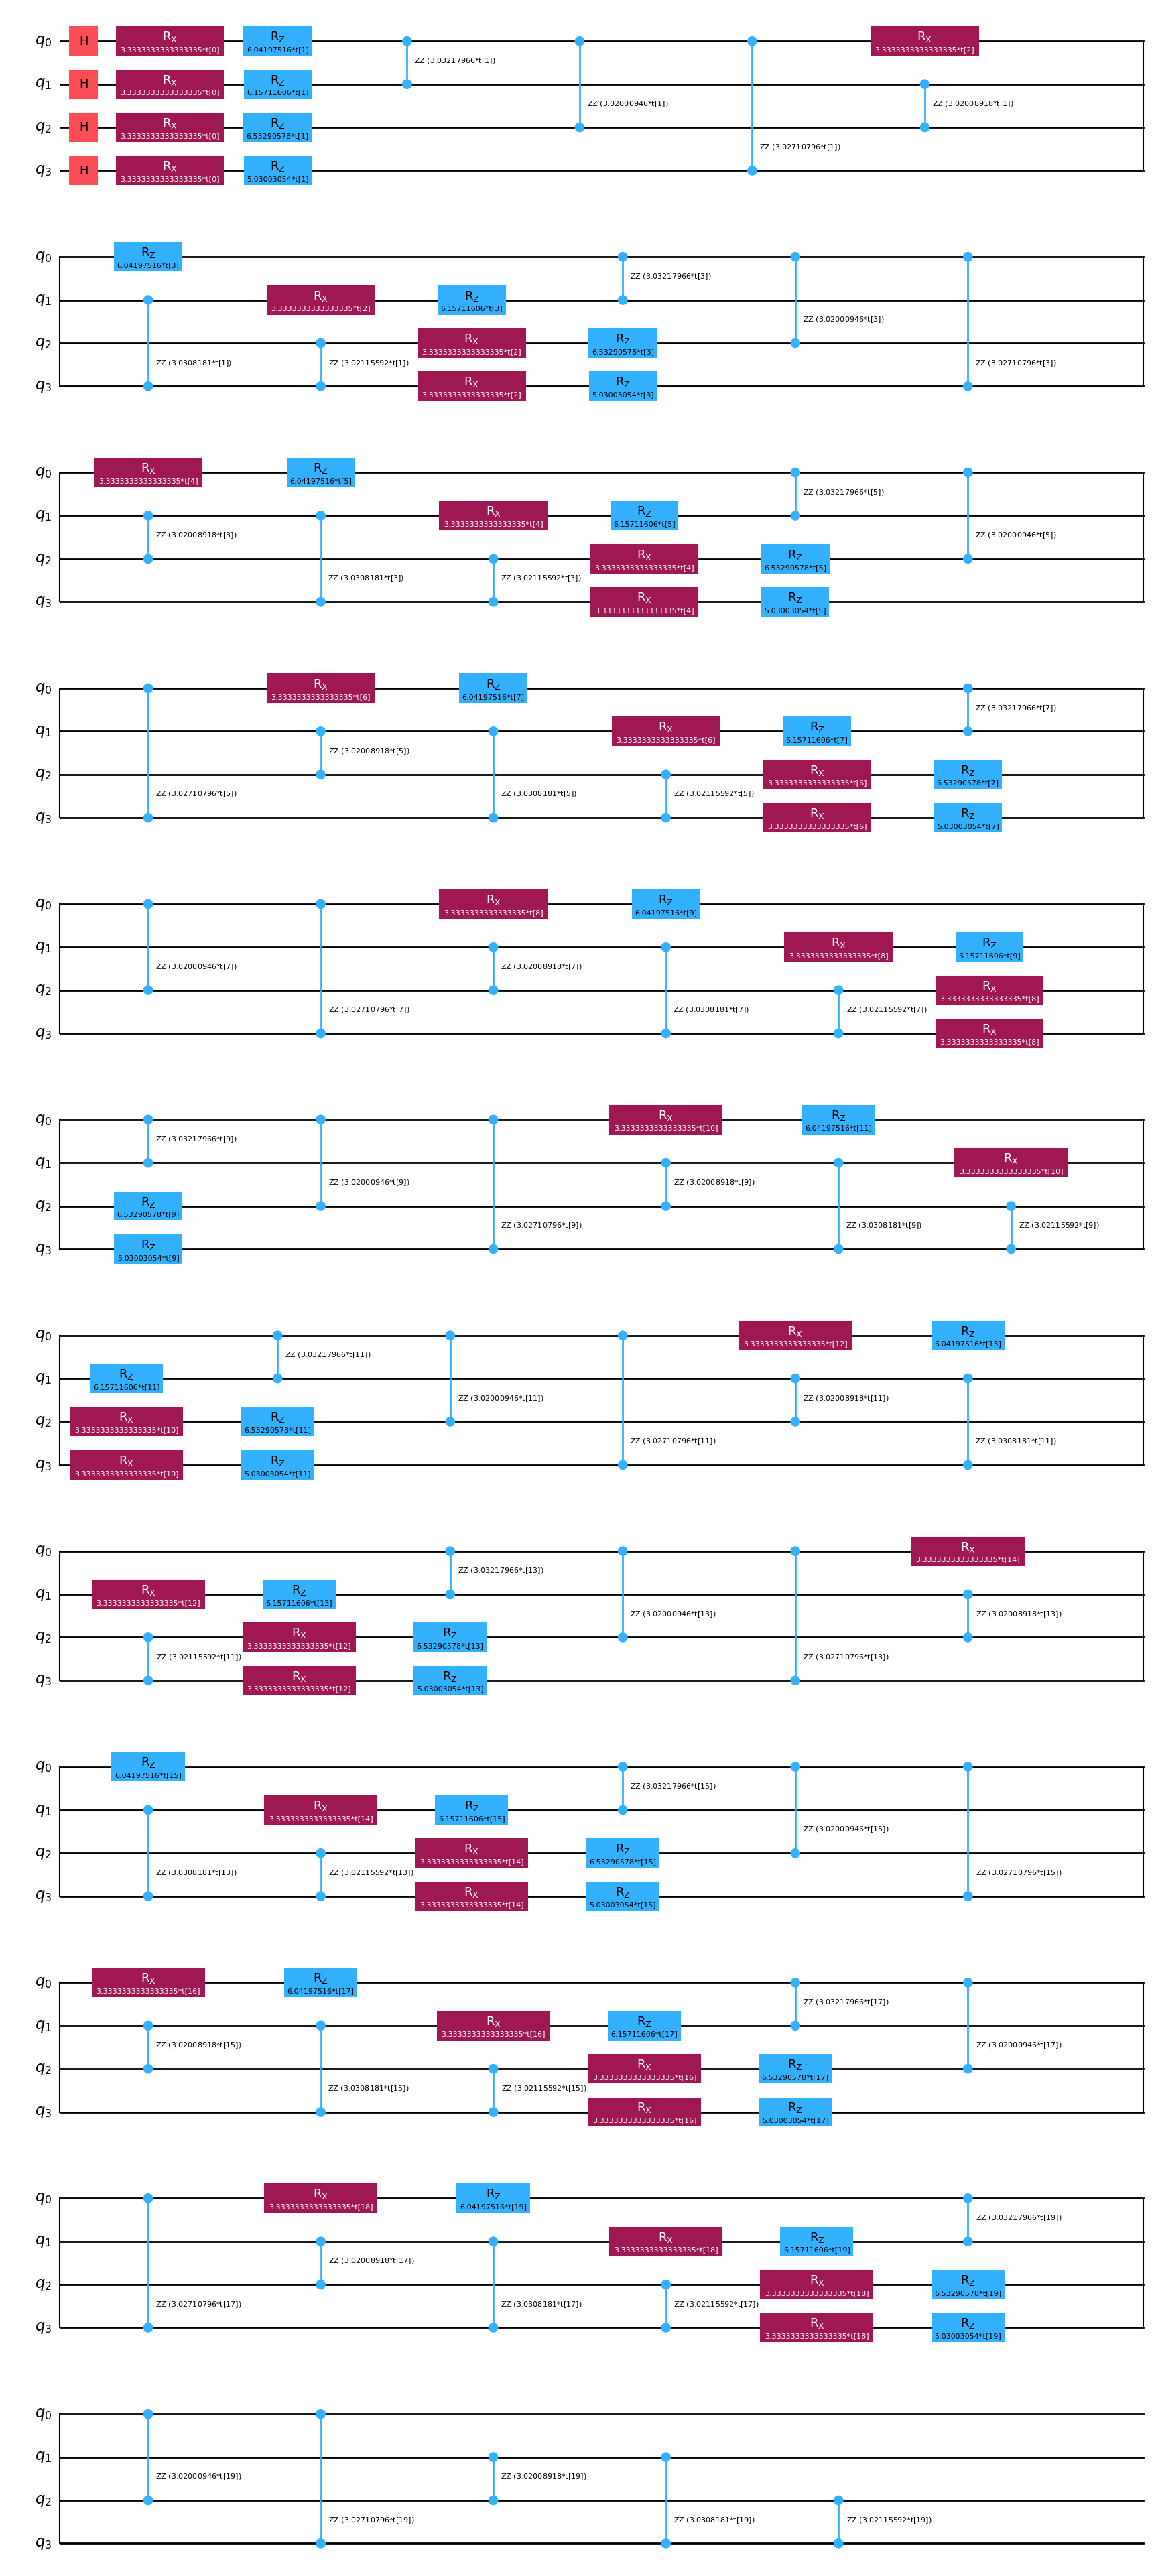

In [40]:
import numpy as np

from qiskit.circuit.library import hamiltonian_variational_ansatz
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit

num_qubits = 4
initial_state = QuantumCircuit(num_qubits)
initial_state.h(range(num_qubits))

mixer_terms = [
                ("I" * left + "X" + "I" * (num_qubits - left - 1), 0.5 * delta_t) for left in range(num_qubits)
            ]
mixer = SparsePauliOp.from_list(mixer_terms)
print(mixer)
# print(mixer.num_parameters)
# for k in range(1, r+1):
#     gamma = calc_gamma(k*delta_t, T, lambda_vec)
#     print(gamma)
#     mixer_terms = [
#                 ("I" * left + "X" + "I" * (num_qubits - left - 1), gamma) for left in range(num_qubits)
#             ]
#     mixer = SparsePauliOp.from_list(mixer_terms)
#     # initial_state.append(hamiltonian_variational_ansatz(mixer, 1))
#     final_state = initial_state.compose(hamiltonian_variational_ansatz(mixer, r))

cost = SparsePauliOp(['IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[3.02098758+0.j, 3.07855803+0.j, 3.26645289+0.j, 2.51501527+0.j,
 1.51608983+0.j, 1.51000473+0.j, 1.51355398+0.j, 1.51004459+0.j,
 1.51540905+0.j, 1.51057796+0.j])
print(cost)

final_state = initial_state.compose(hamiltonian_variational_ansatz([mixer, cost], reps=T))
final_state.draw('mpl')